# Demonstration - Filter and noise basics

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage

%matplotlib inline

## Creating noise images with different distributions

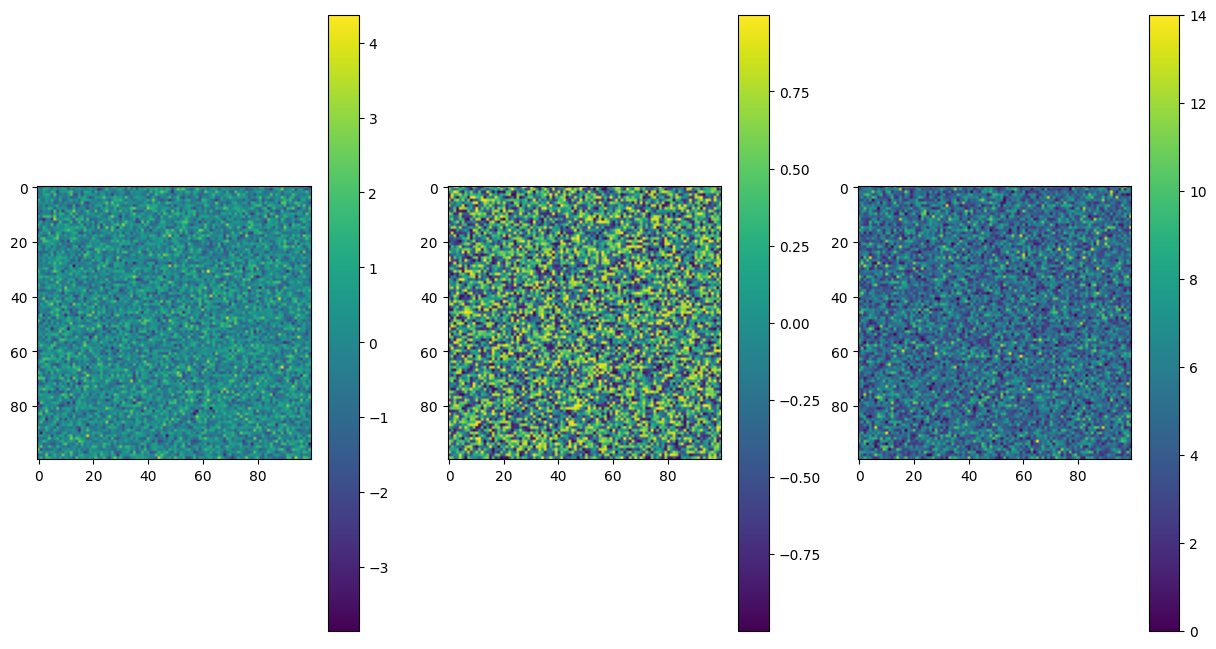

In [2]:
nimg = np.random.normal(0,1,size=[100,100])
uimg = np.random.uniform(-1,1,size=[100,100])
pimg = np.random.poisson(5,size=[100,100])

plt.figure(figsize=[15,8])

plt.subplot(1,3,1)
plt.imshow(nimg)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(uimg)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(pimg)
plt.colorbar()

## Applying different filters

/tmp/ipykernel_21619/3918440039.py:1: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  gimg=ndimage.filters.gaussian_filter(nimg,1.0)
/tmp/ipykernel_21619/3918440039.py:2: DeprecationWarning: Please import `uniform_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  fimg=ndimage.filters.uniform_filter(nimg,3)
/tmp/ipykernel_21619/3918440039.py:3: DeprecationWarning: Please import `median_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  mimg=ndimage.filters.median_filter(nimg,3)
/tmp/ipykernel_21619/3918440039.py:4: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  aimg=ndimage

Text(0.5, 1.0, 'Convolve (binomial)')

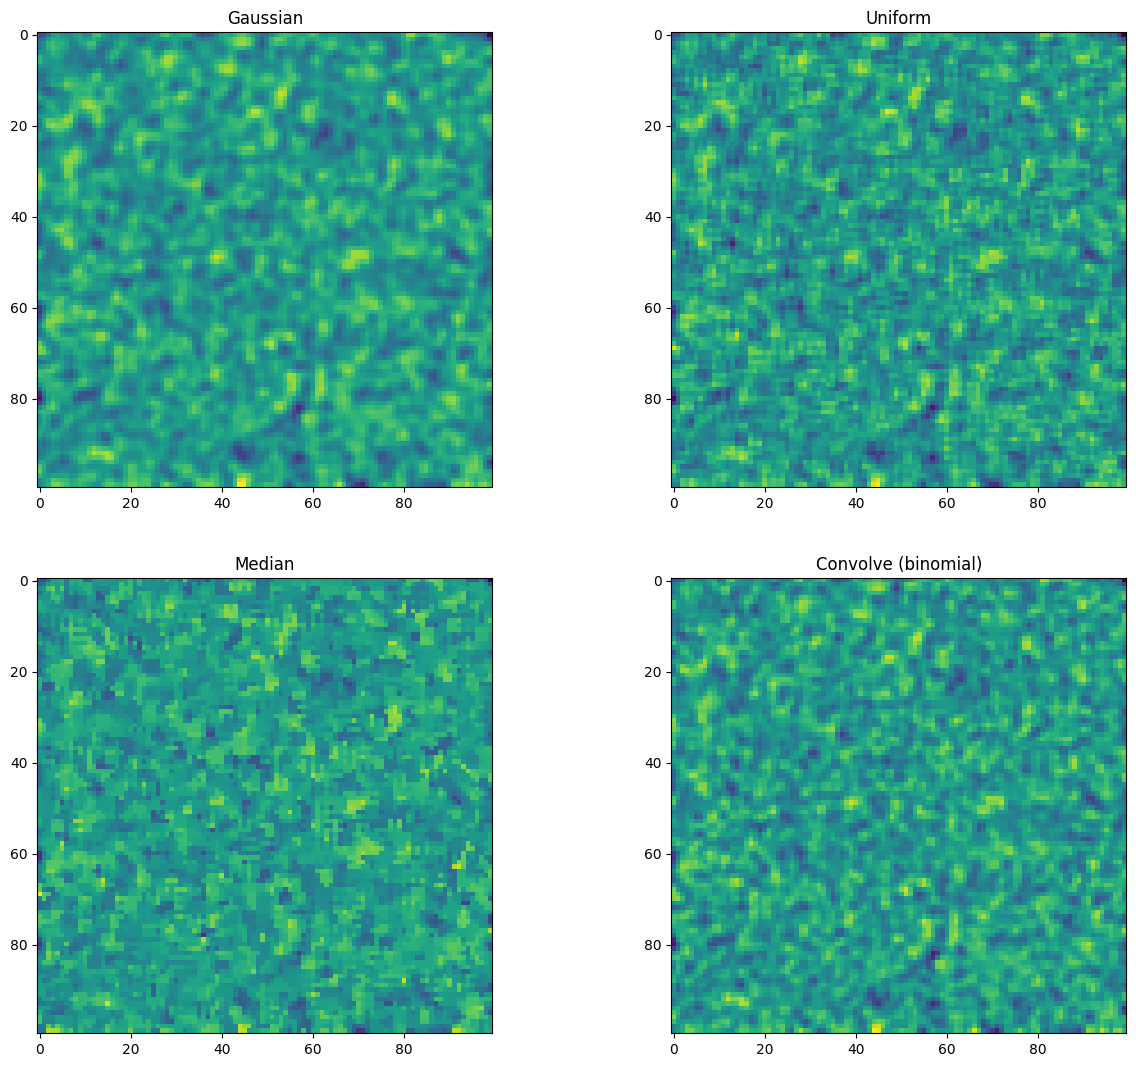

In [3]:
gimg=ndimage.filters.gaussian_filter(nimg,1.0)
fimg=ndimage.filters.uniform_filter(nimg,3)
mimg=ndimage.filters.median_filter(nimg,3)
aimg=ndimage.filters.convolve(nimg,[[1,2,1],[2,4,2],[1,2,1]])

plt.figure(figsize=[15,13])
plt.subplot(2,2,1)
plt.imshow(gimg)
plt.title('Gaussian')

plt.subplot(2,2,2)
plt.imshow(fimg)
plt.title('Uniform')

plt.subplot(2,2,3)
plt.imshow(mimg)
plt.title('Median')

plt.subplot(2,2,4)
plt.imshow(aimg)
plt.title('Convolve (binomial)')

# Demonstrating edge blurring
We want to observe what happens with edges when the image is filtered using different filter kernels.

## Make test data
The test data is a wedge structure with increasing gap width.

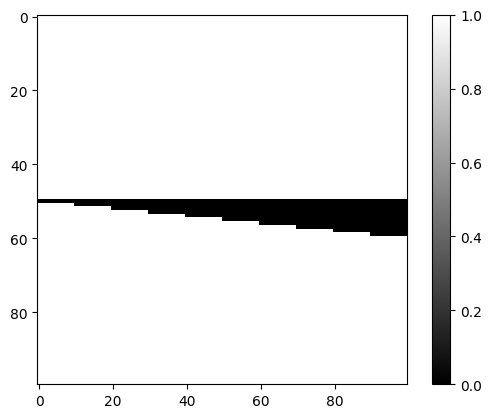

In [4]:
img=np.zeros([100,100])
img[0:50,:]=1
for i in range(img.shape[0]) :
    img[(51+int(i/10)):img.shape[0],i]=1
    
plt.imshow(img,cmap='gray')
plt.colorbar()

## Evaluate under different conditions
 - Add noise of different strength
 - Apply different uniform filter kernels
 - Observe what happens on thresholded data

## Make noisy image

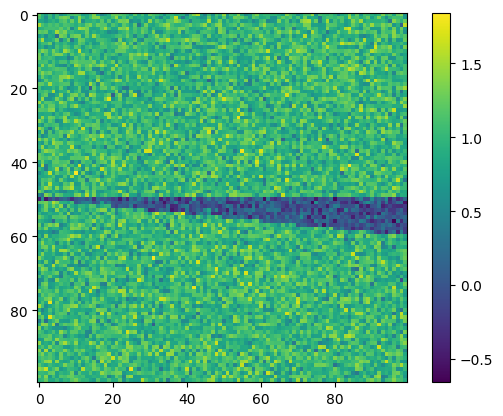

In [5]:
SNR=4
sigma=1/SNR 

noise=np.random.normal(0,sigma,img.shape)
nimg=img+noise
plt.imshow(nimg)
plt.colorbar()

/tmp/ipykernel_21619/610808705.py:24: DeprecationWarning: Please import `uniform_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  fimg=ndimage.filters.uniform_filter(nimg,N)


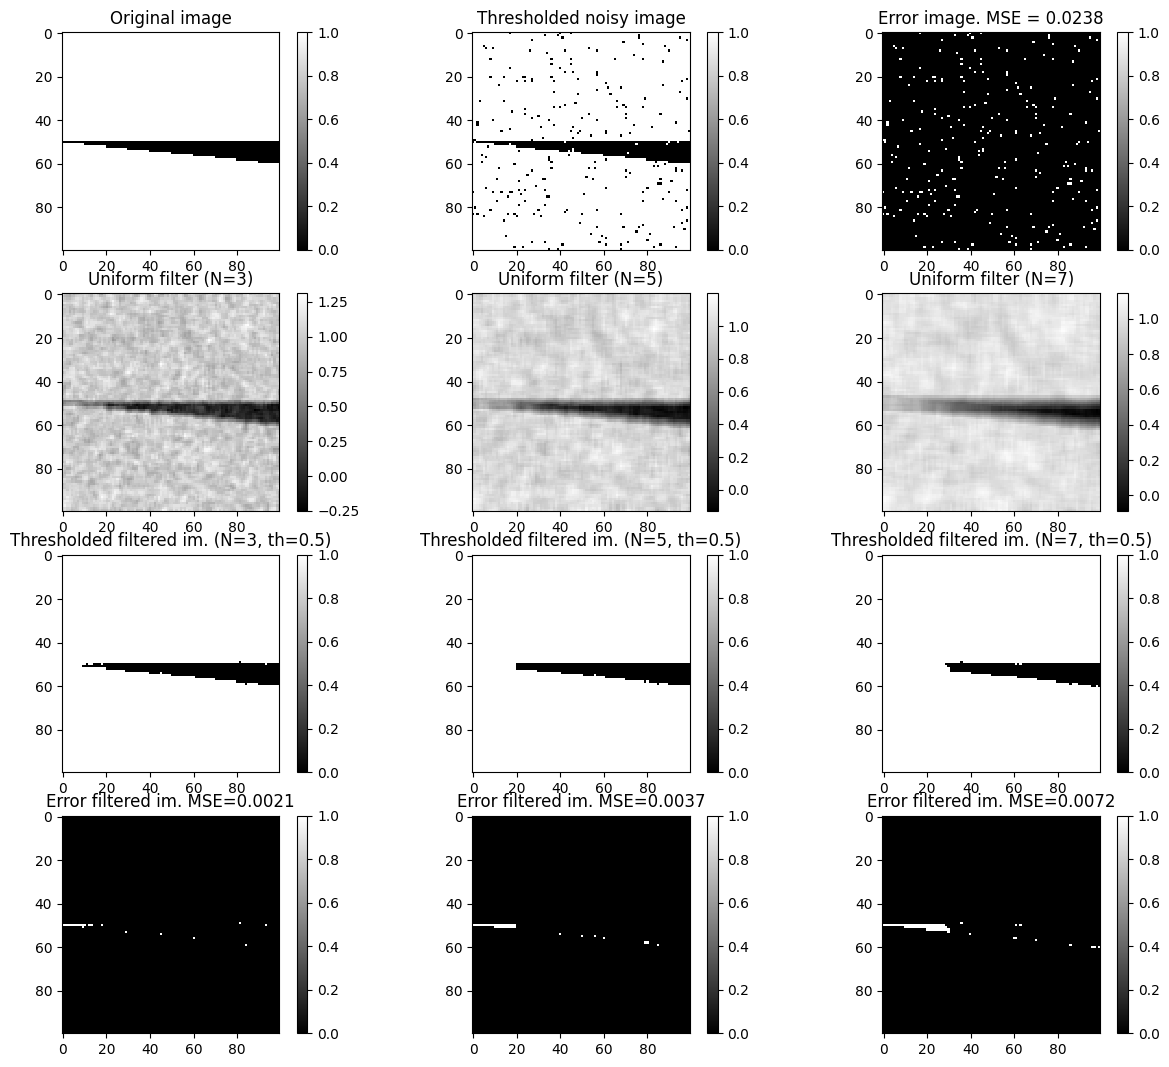

In [6]:
threshold = 0.5 # Threshold for segmentation

fig=plt.figure(figsize=[15,13])
for i in range(3) :
    if (i==0):
        plt.subplot(4,3,i+1)
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.colorbar()
        plt.title('Original image')
    if (i==1) :
        plt.subplot(4,3,i+1)
        plt.imshow(threshold<nimg, cmap='gray', interpolation='none')
        plt.colorbar()
        plt.title('Thresholded noisy image')
    if (i==2) :
        error_image = (img - (threshold<nimg))**2
        plt.subplot(4,3,i+1)
        plt.imshow(error_image, cmap='gray', interpolation='none')
        plt.colorbar()
        plt.title(f'Error image. MSE = {np.mean(error_image)}')
    
    plt.subplot(4,3,3+i+1)
    N=3+i*2
    fimg=ndimage.filters.uniform_filter(nimg,N)
    plt.imshow(fimg, cmap='gray', interpolation='none')
    plt.colorbar()
    plt.title(f'Uniform filter (N={N})')

    plt.subplot(4,3,6+i+1)
    plt.imshow((threshold<fimg),cmap='gray',interpolation='none')
    plt.colorbar()
    plt.title(f'Thresholded filtered im. (N={N}, th={threshold})')

    error_image = (img - (threshold<fimg))**2
    plt.subplot(4,3,9+i+1)
    plt.imshow(error_image,cmap='gray',interpolation='none')
    plt.colorbar()
    plt.title(f'Error filtered im. MSE={np.mean(error_image)}')

The effect of the filter is as you can see that the SNR is improving but at the cost of lost details

# An interactive playground for filters and noise
Execute all cells in the notebook and start playing with different combinations of 
- Images
- Filters
- Noise

You can also test what happens when you use different parameters.

In [7]:
from warnings import warn
from skimage.morphology import disk, octagon as oct_func, star, square
from skimage.restoration import denoise_nl_means, denoise_wavelet
from scipy import ndimage as ndi
from skimage.filters import gaussian, median
import ipywidgets as ipw
from IPython.display import display, update_display, clear_output
from skimage.color import rgb2gray
import skimage.data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# To prevent automatic figure display when execution of the cell ends
%config InlineBackend.close_figures = False


def horizontal_line(n):
    return np.pad(np.ones((1, 2*n+1)), [[n, n], [0, 0]], mode='constant', constant_values=0).astype(int)


def vertical_line(n):
    return horizontal_line(n).T


def cross(n):
    return ((horizontal_line(n)+vertical_line(n)) > 0).astype(int)


def octagon(n):
    return oct_func(n, n)

In [8]:
def clean_img(x):
    if isinstance(x, tuple):
        x = x[0]
    if len(x.shape) == 3:
        y = rgb2gray(x)
    else:
        y = x
    if y.dtype == np.uint8:
        y = y/255.0
    if y.dtype == bool:
        y = y/1.0
    return y


sample_images = {c_id: clean_img(getattr(skimage.data, c_id)()) for c_id in ['astronaut',
                                                                             'camera',
                                                                             'checkerboard',
                                                                             'chelsea',
                                                                             'clock',
                                                                             'coffee',
                                                                             'coins',
                                                                             'horse',
                                                                             'hubble_deep_field',
                                                                             'immunohistochemistry',
                                                                             'moon',
                                                                             'page',
                                                                             'text',
                                                                             'rocket',
                                                                             'stereo_motorcycle']}


def salt_and_pepper(x, strength):
    y = x.copy()
    y[np.random.uniform(0, 1, size=x.shape) < strength/2.0] = x.min()
    y[np.random.uniform(0, 1, size=x.shape) < strength/2.0] = x.max()
    return y


def additive_gaussian(x, strength):
    return x+np.random.normal(0, strength, size=x.shape)


def multiplicative_gaussian(x, strength):
    return x*np.random.normal(1, strength, size=x.shape)


def horizontally_streaky_salt(x, strength):
    y = x.copy()
    y[np.random.uniform(0, 1, size=x.shape[0]) < strength/2.0, :] = x.min()
    y[np.random.uniform(0, 1, size=x.shape[0]) < strength/2.0, :] = x.max()
    return y


def vertically_streaky_salt(x, strength):
    y = x.copy()
    y[:, np.random.uniform(0, 1, size=x.shape[1]) < strength/2.0] = x.min()
    y[:, np.random.uniform(0, 1, size=x.shape[1]) < strength/2.0] = x.max()
    return y


def no_filter(x, **kwargs):
    return x


def gaussian_filter(x, size, neighborhood):
    # gaussian from skimage doesn't implement custom neighborhood
    base_kernel = neighborhood(size)
    impulse_img = np.zeros_like(base_kernel, dtype=np.float32)
    impulse_img[impulse_img.shape[0]//2, impulse_img.shape[1]//2] = 1.0
    g_kernel = gaussian(impulse_img, sigma=size)
    g_kernel = g_kernel*base_kernel
    g_kernel /= g_kernel.sum()
    return ndi.convolve(x, g_kernel, mode='constant', cval=0.0)


def median_filter(x, size, neighborhood):
    return median((x*255).clip(0, 255).astype(np.uint8), neighborhood(size))/255.0


def nonlocal_means(x, size, neighborhood):
    if neighborhood.__name__ != 'square':
        warn('Nonlocal means only uses square filters', RuntimeWarning)
    return denoise_nl_means(x, patch_size=size)


def wavelet_filter(x, size, neighborhood):
    if neighborhood.__name__ != 'square':
        warn('Wsvelet means only uses square filters', RuntimeWarning)
    return denoise_wavelet(x, sigma=size)

In [9]:
plt.ioff()
fig, m_axs = plt.subplots(2, 2, figsize=(12, 9), dpi=120)
mpl_out = ipw.Output()


def show_results(m_axs, in_img, noise_func, noise_strength, filter_func, filter_args):
    ((ax_img, ax_noise), (ax_filt, ax_diff)) = m_axs
    plot_args = dict(cmap='bone', vmin=0, vmax=1)
    ax_img.imshow(in_img, **plot_args)
    ax_img.axis('off')
    ax_img.set_title('Original Image')

    noise_img = noise_func(in_img, noise_strength)

    ax_noise.imshow(noise_img, **plot_args)
    ax_noise.set_title('Noise Image\n%s (%2.1f%%)\nMSE: %2.2f%%' % (noise_func.__name__, 100*noise_strength,
                                                                    100*np.mean(np.square(noise_img-in_img))))
    ax_noise.axis('off')

    filt_img = filter_func(noise_img, **filter_args)

    ax_filt.imshow(filt_img, **plot_args)
    f_args_str = '\n'.join(['{} = {}'.format(k, getattr(v, '__name__', v))
                            for k, v in filter_args.items()]) if len(filter_args) > 0 else ''
    ax_filt.set_title('{}\n{}'.format(filter_func.__name__, f_args_str))
    ax_filt.axis('off')

    diff_img = filt_img-in_img
    v_max = np.abs(diff_img).max()
    ax_diff.imshow(diff_img, cmap='RdBu', vmin=-v_max, vmax=v_max)
    ax_diff.set_title('Difference Image\nMSE: %2.2f%%' %
                      (100*np.mean(np.square(diff_img))))
    ax_diff.axis('off')


def fn_dict(x): return [(getattr(f, '__name__', f), f) for f in x]


image_name = ipw.Dropdown(options=sample_images.keys())
noise_func = ipw.Dropdown(options=fn_dict([salt_and_pepper, additive_gaussian,
                                           multiplicative_gaussian,
                                           vertically_streaky_salt,
                                           horizontally_streaky_salt]))
noise_level = ipw.FloatSlider(min=0, max=1, value=0.1, step=0.025)
filter_func = ipw.Dropdown(options=fn_dict(
    [no_filter, gaussian_filter, median_filter, nonlocal_means, wavelet_filter]))

neighbor_functions = [square, disk, cross,
                      horizontal_line, vertical_line, star, octagon]
filter_shape = ipw.Dropdown(options=fn_dict(neighbor_functions))
filter_size = ipw.IntSlider(min=1, max=50, value=3)


def update_image(*args):
    show_results(m_axs,
                 sample_images[image_name.value],
                 noise_func.value,
                 noise_level.value,
                 filter_func.value,
                 {'size': filter_size.value,
                  'neighborhood': filter_shape.value
                  })
    with mpl_out:
        clear_output(wait=True)
        display(fig)


update_image()

# add callbacks
image_name.observe(update_image, names='value')
noise_func.observe(update_image, names='value')
noise_level.observe(update_image, names='value')
filter_func.observe(update_image, names='value')
filter_shape.observe(update_image, names='value')
filter_size.observe(update_image, names='value')

display(ipw.VBox([ipw.VBox([ipw.HBox([ipw.Label(value='Image Name:'), image_name]),
                            ipw.HBox(
                                [ipw.Label(value='Noise Type:'), noise_func]),
                            ipw.HBox(
                                [ipw.Label(value='Noise Level:'), noise_level]),
                            ipw.HBox(
                                [ipw.Label(value='Filter Name:'), filter_func]),
                            ipw.HBox(
                                [ipw.Label(value='Filter Shape:'), filter_shape]),
                            ipw.HBox(
                                [ipw.Label(value='Filter Size:'), filter_size]),
                            mpl_out
                            ])]))